<a href="https://colab.research.google.com/github/Taufiquzzaman-Emon/Detection-of-Malignant-Brain-Tumors-Utilizing-Convolutional-Neural-Networks-and-Decision-Trees/blob/main/Malignant_Brain_Tumor_detection_using_CNN_and_Decision_Tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import shutil
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from IPython.display import clear_output
RANDOM_SEED = 123

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
IMG_PATH = '/content/drive/MyDrive/brain_tumor_dataset'

# Create new folders for TRAIN, TEST, and VAL
os.makedirs('TRAIN/YES', exist_ok=True)
os.makedirs('TRAIN/NO', exist_ok=True)
os.makedirs('TEST/YES', exist_ok=True)
os.makedirs('TEST/NO', exist_ok=True)
os.makedirs('VAL/YES', exist_ok=True)
os.makedirs('VAL/NO', exist_ok=True)

# Split the data into train/val/test
all_images = os.listdir(IMG_PATH)
train_images, test_val_images = train_test_split(all_images, test_size=0.2, random_state=42)
val_images, test_images = train_test_split(test_val_images, test_size=0.5, random_state=42)

# Organize images into TRAIN, TEST, and VAL directories
for img in train_images:
    label = 'YES' if img.startswith('Y') else 'NO'
    shutil.copy(os.path.join(IMG_PATH, img), os.path.join('TRAIN', label, img))

for img in val_images:
    label = 'YES' if img.startswith('Y') else 'NO'
    shutil.copy(os.path.join(IMG_PATH, img), os.path.join('VAL', label, img))

for img in test_images:
    label = 'YES' if img.startswith('Y') else 'NO'
    shutil.copy(os.path.join(IMG_PATH, img), os.path.join('TEST', label, img))


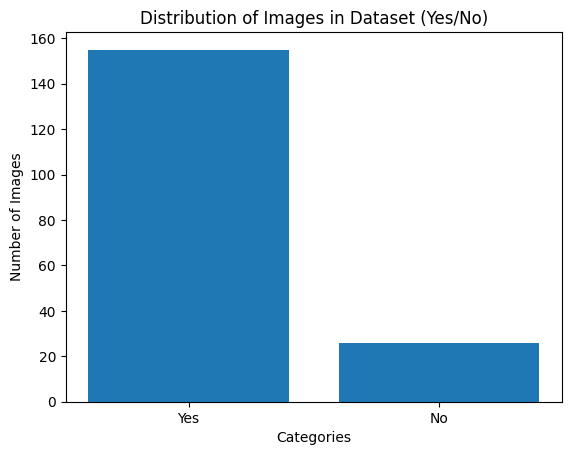

In [ ]:
# Define the path to your dataset
IMG_PATH = '/content/drive/MyDrive/brain_tumor_dataset'

# List all files in the dataset directory
file_list = os.listdir(IMG_PATH)

# Separate filenames starting with 'Y' and 'N'
yes_images = [file for file in file_list if file.startswith('Y')]
no_images = [file for file in file_list if file.startswith('N')]

# Count the number of images in each category
num_yes_images = len(yes_images)
num_no_images = len(no_images)

# Prepare data for scatter plot
categories = ['Yes', 'No']
num_images_per_category = [num_yes_images, num_no_images]

# Plotting the scatter plot
plt.bar(categories, num_images_per_category)
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.title('Distribution of Images in Dataset (Yes/No)')
plt.show()


In [ ]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    img = cv2.resize(img, img_size)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [ ]:
from tqdm import tqdm

TRAIN_DIR = '/content/TRAIN/'
TEST_DIR = '/content/TEST/'
VAL_DIR = '/content/VAL/'
IMG_SIZE = (224,224)

X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:01<00:00,  1.54it/s]


202 images loaded from /content/TRAIN/ directory.


100%|██████████| 2/2 [00:00<00:00,  6.30it/s]


26 images loaded from /content/TEST/ directory.


100%|██████████| 2/2 [00:00<00:00,  8.91it/s]

25 images loaded from /content/VAL/ directory.


In [ ]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

In [ ]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

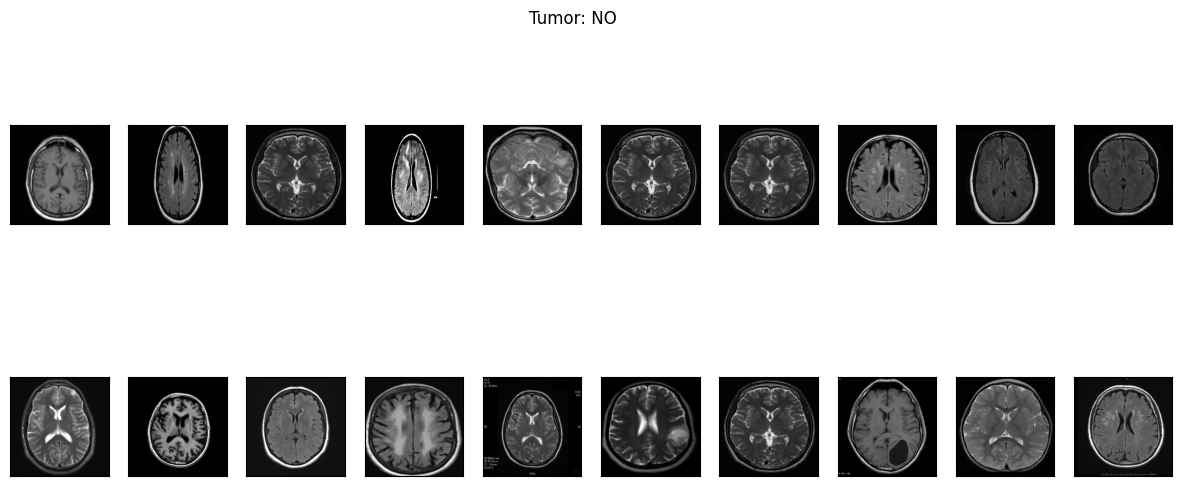

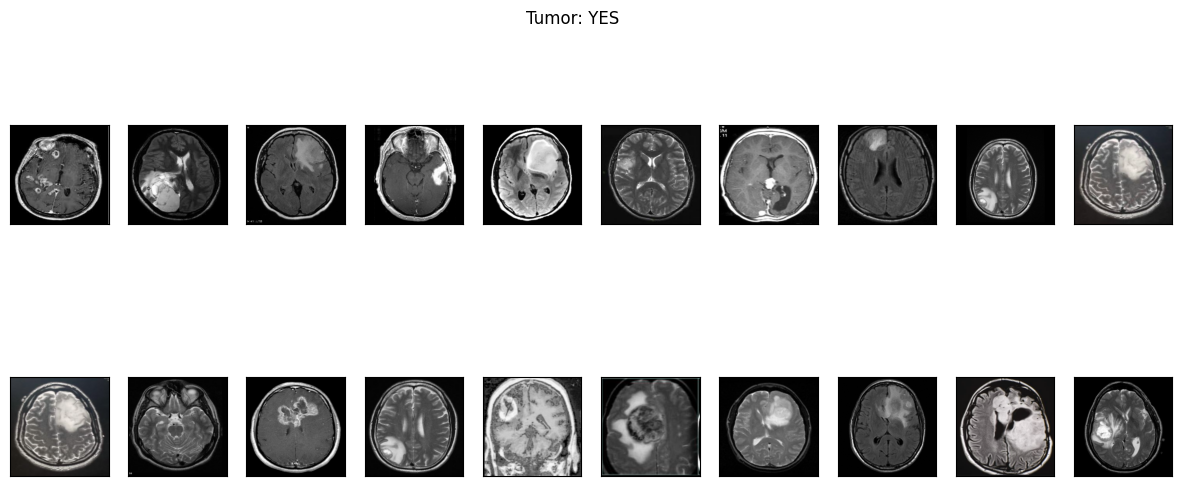

In [ ]:
plot_samples(X_train, y_train, labels, 20)

In [ ]:
import imgaug as ia
import imgaug.augmenters as iaa
import imutils
import numpy as np
from google.colab.patches import cv2_imshow

img = cv2.imread('/content/TRAIN/YES/Y11.jpg')

IMG_SIZE = (224, 224)

X_train_crop = []
augmentation = iaa.Sequential([
    iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}),
    iaa.Affine(shear=(-20, 20))
])
for img in X_train:
    img_resized = cv2.resize(img, dsize=IMG_SIZE, interpolation=cv2.INTER_CUBIC)
    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    ADD_PIXELS = 0
    cropped_img = img_resized[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
    augmented_image = augmentation(image=cropped_img)
    X_train_crop.append(augmented_image)
X_train_crop_resized = np.array([cv2.resize(img, (224, 224)) for img in X_train_crop])

X_train_crop_resized = X_train_crop_resized.reshape(X_train_crop_resized.shape[0], 224, 224, 3)




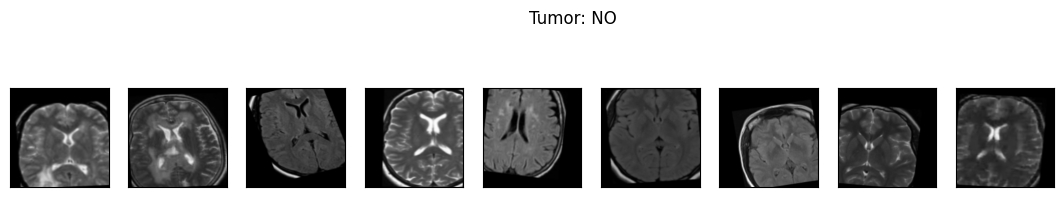

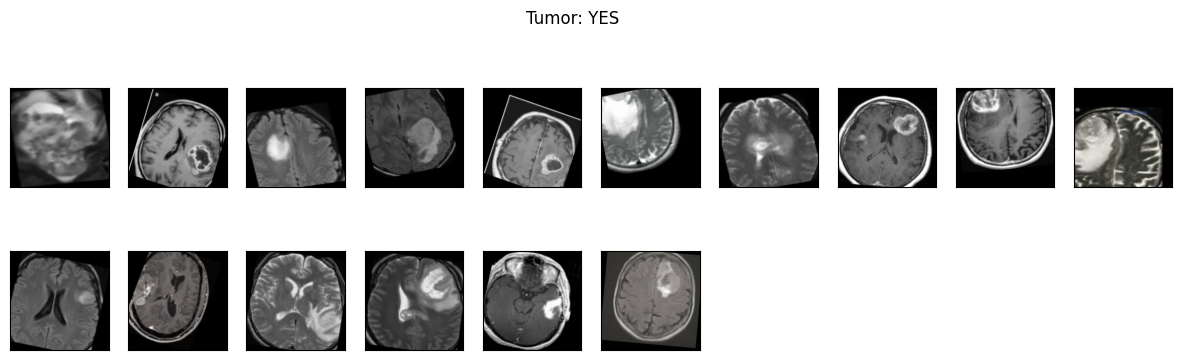

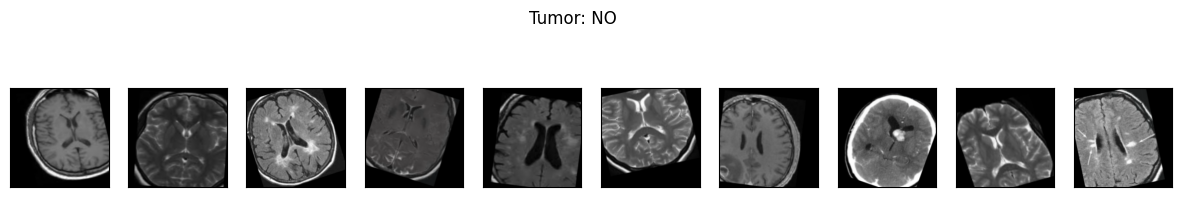

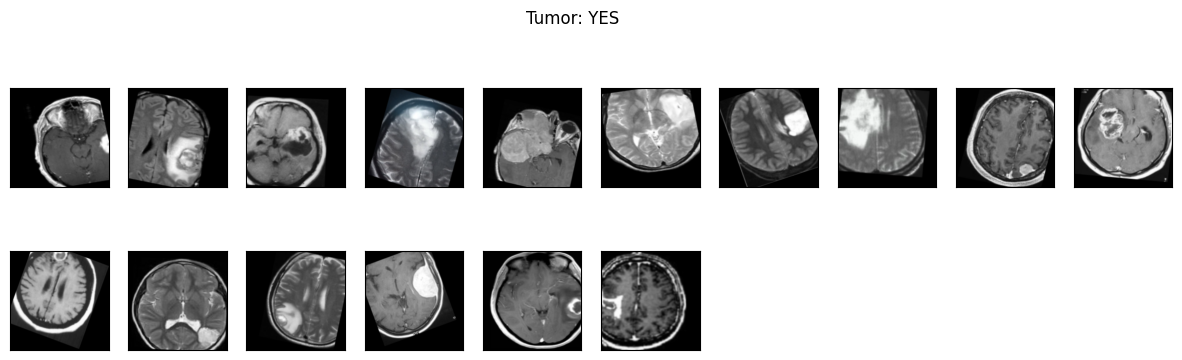

In [ ]:
import cv2
X_val_crop = []
X_test_crop = []
for img in X_val:
    img_resized = cv2.resize(img, dsize=IMG_SIZE, interpolation=cv2.INTER_CUBIC)
    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    ADD_PIXELS = 0
    cropped_img = img_resized[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
    augmented_image = augmentation(image=cropped_img)
    X_val_crop.append(augmented_image)

X_val_crop_resized = np.array([cv2.resize(img, IMG_SIZE) for img in X_val_crop])

for img in X_test:
    img_resized = cv2.resize(img, dsize=IMG_SIZE, interpolation=cv2.INTER_CUBIC)
    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    ADD_PIXELS = 0
    cropped_img = img_resized[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
    augmented_image = augmentation(image=cropped_img)
    X_test_crop.append(augmented_image)

X_test_crop_resized = np.array([cv2.resize(img, IMG_SIZE) for img in X_test_crop])
plot_samples(X_val_crop_resized, y_val, labels, 30)
plot_samples(X_test_crop_resized, y_test, labels, 30)


In [ ]:
!mkdir TRAIN_CROP TRAIN_CROP/YES TRAIN_CROP/NO
!mkdir TEST_CROP TEST_CROP/YES TEST_CROP/NO
!mkdir VAL_CROP VAL_CROP/YES VAL_CROP/NO

In [ ]:
def save_new_images(images, labels, folder_name):

    if not os.path.exists(folder_name):
        os.makedirs(folder_name)


    for image, label in zip(images, labels):

        class_folder = os.path.join(folder_name, 'YES' if label == 1 else 'NO')
        if not os.path.exists(class_folder):
            os.makedirs(class_folder)

        image_path = os.path.join(class_folder, f'img_{len(os.listdir(class_folder)) + 1}.jpg')
        cv2.imwrite(image_path, image)

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    '/content/TRAIN_CROP',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    '/content/VAL_CROP',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

history = model.fit(train_generator, epochs=20, validation_data=val_generator)


58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 27560769 (105.14 MB)
Trainable params: 12846081 (49.00 MB)
Non-trainable params: 14714688 (56.13 MB)
________

In [ ]:
model.save('CNN.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



1/1 [==============================] - 1s 839ms/step


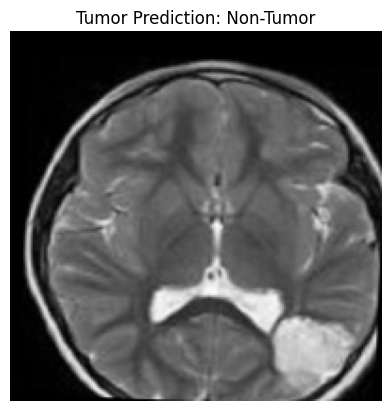

Raw Output Score: 0.14725831151008606


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
test_image = cv2.imread('/content/TEST_CROP/YES/img_12.jpg')

IMG_SIZE = (224, 224)
test_image_resized = cv2.resize(test_image, dsize=IMG_SIZE, interpolation=cv2.INTER_CUBIC)
test_image_normalized = test_image_resized / 255.0
test_image_input = np.expand_dims(test_image_normalized, axis=0)

cnn_model = load_model('CNN.h5')
predictions = cnn_model.predict(test_image_input)

threshold = 0.6
if predictions[0][0] > threshold:
    prediction_label = "Tumor"
else:
    prediction_label = "Non-Tumor"
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
plt.title(f'Tumor Prediction: {prediction_label}')
plt.axis('off')
plt.show()
print(f'Raw Output Score: {predictions[0][0]}')



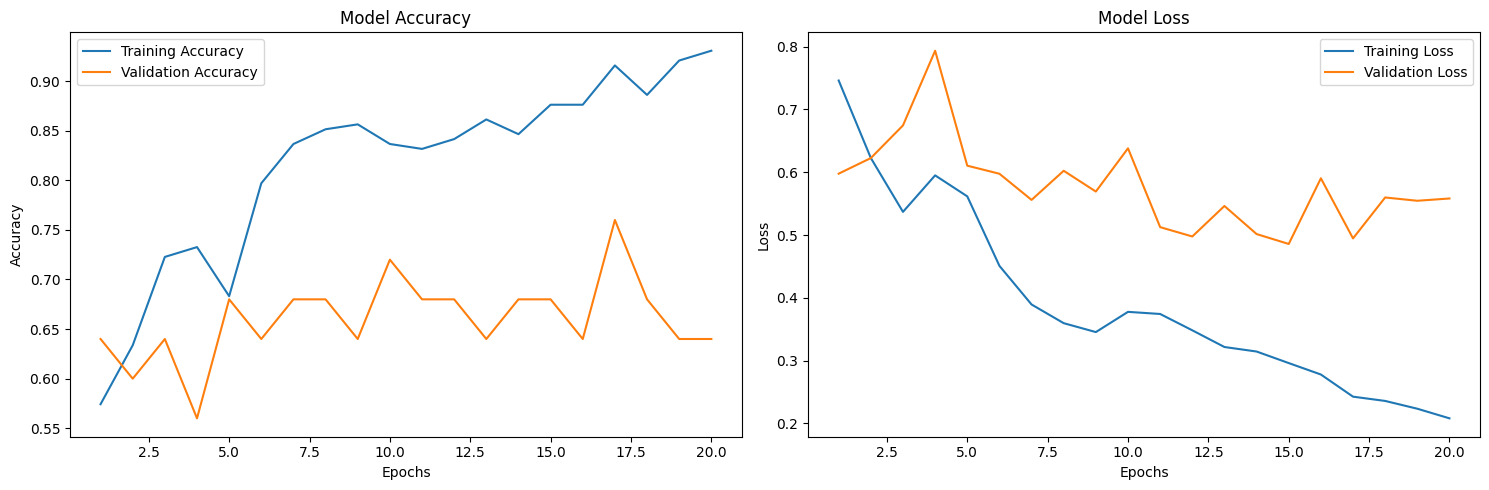

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()


In [ ]:
val_datagen = ImageDataGenerator(rescale=1./255)
val_data_dir = '/content/VAL_CROP'
val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)
y_val_true = np.array(val_generator.classes)


Found 25 images belonging to 2 classes.


In [ ]:
predictions = cnn_model.predict(val_generator)
y_val_pred = np.array([1 if pred > 0.5 else 0 for pred in predictions])
print("Ground truth labels for validation set:")
print(y_val_true)

print("\nPredicted labels for validation set:")
print(y_val_pred)


1/1 [==============================] - 19s 19s/step
Ground truth labels for validation set:
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

Predicted labels for validation set:
[0 1 1 0 0 1 1 0 0 0 0 0 1 0 1 1 1 1 0 1 1 1 1 1 1]


In [ ]:
from sklearn.metrics import classification_report

# Generate classification report
class_report = classification_report(y_val_true, y_val_pred, target_names=['Non-Tumor', 'Tumor'])

# Print classification report
print(class_report)


              precision    recall  f1-score   support

   Non-Tumor       0.50      0.56      0.53         9
       Tumor       0.73      0.69      0.71        16

    accuracy                           0.64        25
   macro avg       0.62      0.62      0.62        25
weighted avg       0.65      0.64      0.64        25



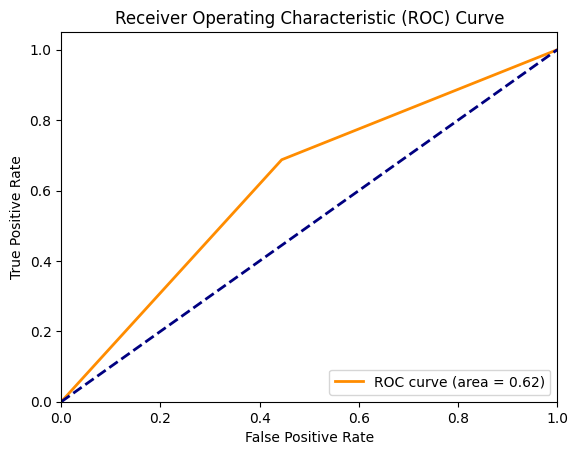

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_val_true, y_val_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


Validation Accuracy: 0.64


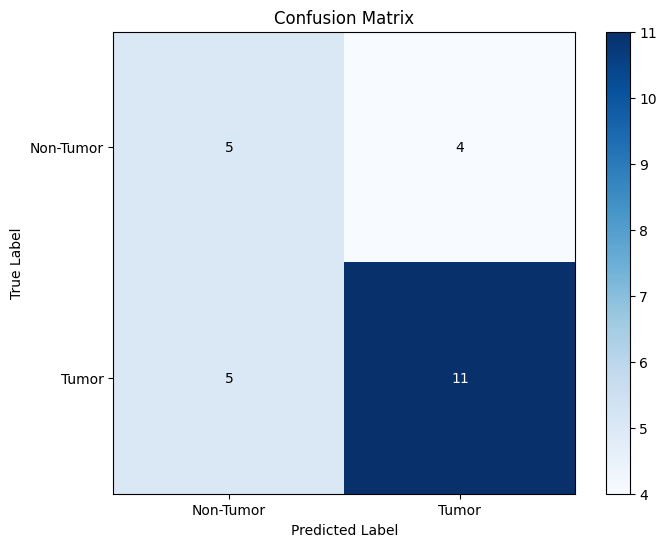

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

threshold = 0.5

y_val_pred = [1 if x > threshold else 0 for x in predictions]

y_val_true = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
accuracy = accuracy_score(y_val_true, y_val_pred)
print('Validation Accuracy: %.2f' % accuracy)


confusion_mtx = confusion_matrix(y_val_true, y_val_pred)


plt.figure(figsize=(8, 6))
plt.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], ['Non-Tumor', 'Tumor'])
plt.yticks([0, 1], ['Non-Tumor', 'Tumor'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')


thresh = confusion_mtx.max() / 2.
for i in range(confusion_mtx.shape[0]):
    for j in range(confusion_mtx.shape[1]):
        plt.text(j, i, format(confusion_mtx[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if confusion_mtx[i, j] > thresh else "black")

plt.show()


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.model_selection import GridSearchCV

def load_images_from_dir(directory):
    images = []
    labels = []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        for filename in os.listdir(label_dir):
            img_path = os.path.join(label_dir, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (224, 224))
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)


def extract_features(images):
    return images.reshape(len(images), -1)


In [ ]:
X_train, y_train = load_images_from_dir('/content/TRAIN_CROP/')
X_test, y_test = load_images_from_dir('/content/TEST_CROP/')
X_train_features = extract_features(X_train)
X_test_features = extract_features(X_test)


In [ ]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


In [ ]:
decision_tree = DecisionTreeClassifier()

grid_search = GridSearchCV(decision_tree, param_grid, cv=5)

grid_search.fit(X_train_features, y_train)
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)


Best Hyperparameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}


In [ ]:
best_decision_tree = DecisionTreeClassifier(**best_params)
best_decision_tree.fit(X_train_features, y_train)

y_pred = best_decision_tree.predict(X_test_features)

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

class_report = classification_report(y_test, y_pred)
print(class_report)


Accuracy: 0.6923076923076923
              precision    recall  f1-score   support

          NO       0.62      0.50      0.56        10
         YES       0.72      0.81      0.76        16

    accuracy                           0.69        26
   macro avg       0.67      0.66      0.66        26
weighted avg       0.68      0.69      0.68        26



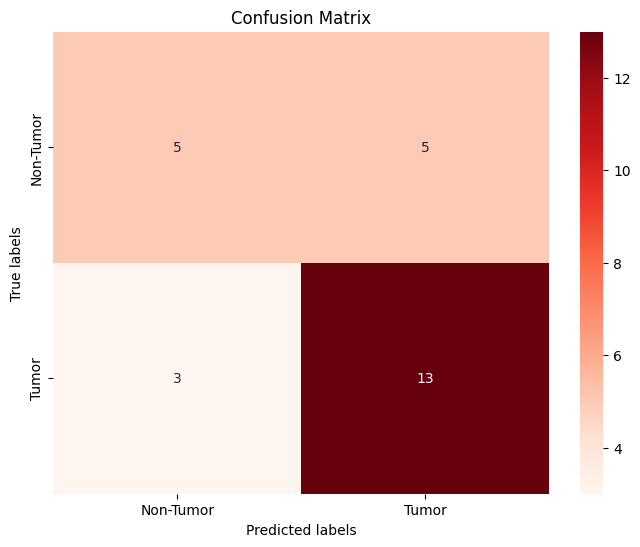

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
labels = ['Non-Tumor', 'Tumor']
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', cbar=True,
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
decision_tree_classifier = DecisionTreeClassifier(**best_params)
decision_tree_classifier.fit(X_train_features, y_train)

DecisionTreeClassifier(max_depth=10)

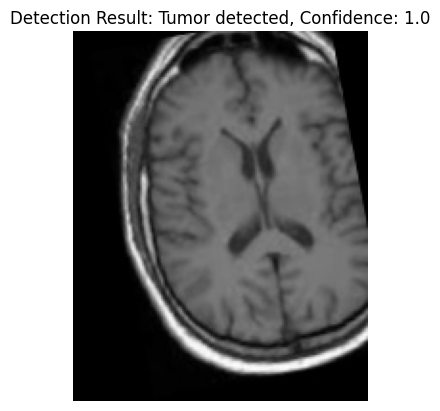

Detection Result: Tumor detected
Confidence Score: 1.0


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def detect_tumor(image_path):

    test_image = cv2.imread(image_path)
    test_image_resized = cv2.resize(test_image, (224, 224))
    test_features = extract_features(np.array([test_image_resized]))
    confidence_score = decision_tree_classifier.predict_proba(test_features)[0][1]
    prediction = decision_tree_classifier.predict(test_features)[0]
    if prediction == 'YES':
        detection_result = "Tumor detected"
    else:
        detection_result = "No tumor detected"
    plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
    plt.title(f'Detection Result: {detection_result}, Confidence: {confidence_score}')
    plt.axis('off')
    plt.show()

    return detection_result, confidence_score, test_image
test_image_path = '/content/TEST_CROP/NO/img_1.jpg'
result, confidence, predicted_image = detect_tumor(test_image_path)
print("Detection Result:", result)
print("Confidence Score:", confidence)



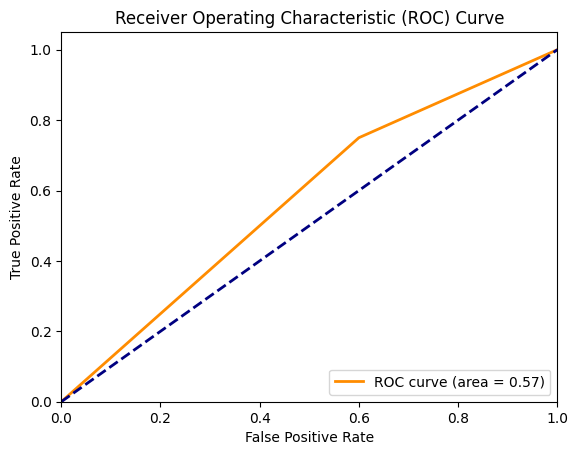

In [ ]:
def plot_roc_curve(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score, pos_label='YES')
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
plot_roc_curve(y_test, decision_tree_classifier.predict_proba(X_test_features)[:, 1])
